```
    ██╗   ██╗ ██████╗ ██╗      █████╗  ██████╗████████╗
    ╚██╗ ██╔╝██╔═══██╗██║     ██╔══██╗██╔════╝╚══██╔══╝
     ╚████╔╝ ██║   ██║██║     ███████║██║        ██║   
      ╚██╔╝  ██║   ██║██║     ██╔══██║██║        ██║   
       ██║   ╚██████╔╝███████╗██║  ██║╚██████╗   ██║   
       ╚═╝    ╚═════╝ ╚══════╝╚═╝  ╚═╝ ╚═════╝   ╚═╝ 
```
## Relevant paper
A simple, fully convolutional model for real-time instance segmentation.
- [YOLACT: Real-time Instance Segmentation](https://arxiv.org/abs/1904.02689)

# Relevant Theory
- Average slip and fall time is about 200-300 ms depending on the height of the person and the average speed they're walking at as they move into the fall. This means that images must be captured at a framerate of at least 5-6 FPS. 

- [Digital Image Processing Theory](http://omercetin.com.tr/DERS/IP/Kitap/2.Principles%20of%20digital%20image%20processing.pdf?i=1)

## Outstanding concerns
Need to construct a table of concerns for each method following the enumeration of the methods fleshed out below. 
- Not enough labelled polygons of people. This may complicate the faster buildout of this option. 


## Approach
        Part 1: 
        Video -> Instance Segmentation (People)

        Part 2:
        1. ML of feature space to separate out fall / no-fall for a single person in a single video. 
        2. OpticalFlow

        Part 3: 
        Video -> Instance Segmentation (People) -> SORT -> Inference of Part 2 features over time. 

## Summary table


### Run Inference on example video

In [67]:
from utils import VideoReaders, DetectorLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import segmentation

In [2]:
frame_provider = VideoReaders.VideoReader('../datasets/slip-fall/fall-database/0026.mp4')
video_length, shape = frame_provider.properties()
model = DetectorLoader.YOLACT('./weights/yolact_resnet50_54_800000.pth', threshold = 0.11)

/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/ubuntu/anaconda3/envs/YOLACT/lib/python3.7/site-packages/torch/jit/_recursive.py:235: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [3]:
output = []
frames = []
boundaries = []

for frame in frame_provider:
    frames.append(frame)
    c, s, bb, ma = model.predict(frame)
    idx = np.where(c == 0)
    pixelwise_arrays = []
    for item in idx:
        for n, qq in enumerate(item):
            pixelwise = np.zeros_like(ma[qq,...])
            pixelwise = ma[qq,...].astype(np.uint8)
            pixelwise[np.where(pixelwise == 1)] = n + 1
            pixelwise_arrays.append(pixelwise)

    filtered = []
    for array in pixelwise_arrays:
        if np.max(array) != 0:
            filtered.append(array)

    stacked = np.sum(filtered, axis = 0)
    output.append(stacked)

for im, mask in zip(frames, output):
    boundaries.append(segmentation.mark_boundaries(im, mask, mode = 'thick', color = (1,0,0)))

## Part 1: Example Outputs

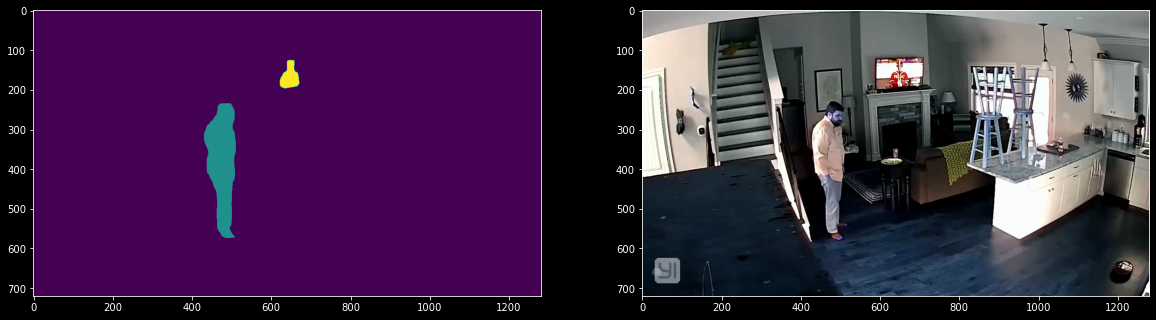

In [4]:
f,ax = plt.subplots(1,2,figsize = (20,20))
ax = ax.flatten()
ax[0].imshow(output[10])
ax[1].imshow(frames[10])

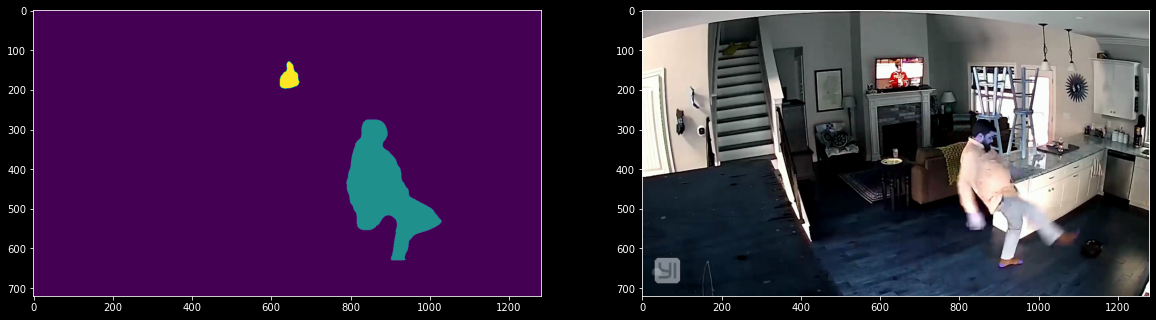

In [5]:
f,ax = plt.subplots(1,2,figsize = (20,20))
ax = ax.flatten()
ax[0].imshow(output[17])
ax[1].imshow(frames[17])

## Part 2: Image moment based analysis
Here I explore the ML feature space to get segmentation of the fall from no fall for the same person in the frame. There is no SORT at this time to link the identity of the person together, though this is readily applicable. 

In [11]:
from skimage import measure
import pandas as pd

In [53]:
dictionary = []
for i in range(0, video_length):
    for region in measure.regionprops(output[i], frames[i]):
        this_normalized_moment = region.moments_normalized
        angle = np.degrees((np.arctan2(2*this_normalized_moment[1,1], this_normalized_moment[2,0] - this_normalized_moment[0,2]))/2)
        dictionary.append({
                        "Frame": i,
                        "ID": region.label, 
                        "Area": region.area, 
                        "Centroid": region.centroid, 
                        "Moments Normalized": region.moments_normalized,
                        "Angle": angle, 
                        "Bbox": region.bbox, 
                        "Eccentricity": region.eccentricity})

In [54]:
test_array = dictionary[20]['Moments Normalized']
dictionary[20]

{'Frame': 10,
 'ID': 1,
 'Area': 17767,
 'Centroid': (386.19243541396975, 476.3886981482524),
 'Moments Normalized': array([[            nan,             nan,  1.83629163e-02,
         -8.73095445e-04],
        [            nan,  1.15192695e-02, -2.96845269e-03,
          5.43934559e-04],
        [ 4.29395928e-01,  1.30178104e-02,  5.61426627e-03,
          1.23119449e-04],
        [ 9.26492624e-02,  9.16727109e-03, -2.61954630e-04,
          2.57609271e-04]]),
 'Angle': 1.6040455088068832,
 'Bbox': (235, 431, 574, 511),
 'Eccentricity': 0.9787840609185071}

In [71]:
dude_angle = []
for diction in dictionary:
    if diction['ID'] == 1:
        dude_angle.append({"Frame": diction['Frame'],"Angle": diction['Angle']})

[Text(0.5, 0, 'Frame'), Text(0, 0.5, 'Angle (Degrees)')]

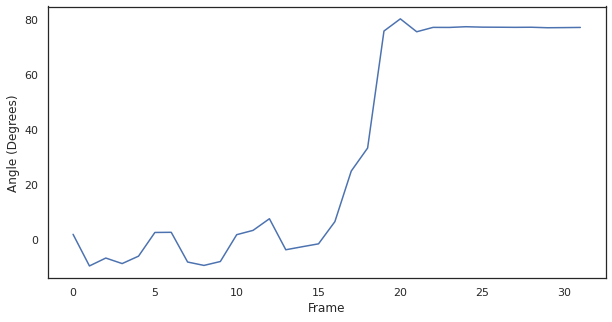

In [81]:
dude_frame = pd.DataFrame(dude_angle)
f,ax = plt.subplots(1, figsize = (10,5))
sns.set_style("white")
ax.plot(dude_frame['Frame'], dude_frame['Angle'])
ax.set(xlabel = 'Frame', ylabel = 'Angle (Degrees)')